In [1]:
#Import Packages
import pandas as pd
import numpy as np
import os
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime
from herbie import Herbie
import pickle
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pysolar.solar as solar
from geographiclib.geodesic import Geodesic
import xarray as xr
import pytz
import atmos_column.ac_funcs as ac
import atmos_column.plotting as plotting
pd.options.mode.chained_assignment = None

#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

 ╭─────────────────────────────────────────────────╮
 │ I'm building Herbie's default config file.      │
 ╰╥────────────────────────────────────────────────╯
 👷🏻‍♂️
 ╭─────────────────────────────────────────────────╮
 │ You're ready to go.                             │
 │ You may edit the config file here:              │
 │ /uufs/chpc.utah.edu/common/home/u0890904/.config/herbie/config.toml   │
 ╰╥────────────────────────────────────────────────╯
 👷🏻‍♂️


/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/atmos_column/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# EM27 Data Load + Basic Analysis

In [3]:
#Initial data load from raw
# on local
raw_em27_data_path = '/Users/agmeyer4/Google Drive/My Drive/Documents/LAIR/Data/SLC_EM27_ha_2022_oof_v2/' 
# on CHPC: '/uufs/chpc.utah.edu/common/home/u0890904/LAIR/Data/SLC_EM27_ha_2022_oof_v2/'
pickle_data_path = '/Users/agmeyer4/Google Drive/My Drive/Documents/LAIR/Data/Pickled_data'

Initial load from raw, save to pickle for easier loading in the future

In [6]:
# Load raw data and dump to pickle
big_df = ac.df_all_oof_in_folder(raw_em27_data_path)
big_df = ac.df_formatter(big_df)

#Dump to pickle
filename = 'wbb_em27_v2.pkl'
with open(os.path.join(pickle_data_path,filename),'wb') as f:
    pickle.dump(big_df,f)

Load from pickle

In [7]:
#Load From pickle
filename = 'wbb_em27_v2.pkl'
with open(os.path.join(pickle_data_path,filename),'rb') as f:
    big_df = pickle.load(f)
flag0_df = big_df.loc[big_df['flag']==0]

# Interesting dates from manual analysis 
filename = 'v2_interesting_dates.pkl'
with open(os.path.join(pickle_data_path,filename),'rb') as f:
    interesting_dates = pickle.load(f)

Look for interesting days: These cells can be repeated and used to identify interesting days, save the ids/dates to a dictionary and pickle file for use later.

In [8]:
#Separate the big dataframe into days. Only run this once. 
date_separated  = []
for idx, day in flag0_df.groupby(flag0_df.index.date):
    date_separated.append(day)

In [9]:
#Initialize the interesting list -- only run this once 
i=-1
interesting_dict = {}


In [11]:
#Run this cell repeatedly when looking for interesting days. When you find one, run the following cell to add it to the interesting dict. 
i+=1
df = date_separated[i]
fig = go.Figure()
fig.add_trace(go.Scatter(
        x = df.index,
        y = df['xch4(ppm)'],
        error_y = dict(
            type='data', # value of error bar given in data coordinates
            array=df['xch4(ppm)_error'],
            visible=True),
        mode='markers',
    ))
fig.show()


In [199]:
#Run this cell to add the above set to the interesting list
interesting_dict[i] = df.index[0].date().strftime('%Y-%m-%d')

In [12]:
#Run this last to save the interesting dict to a pickle file
filename = 'v2_interesting_dates.pkl'
with open(os.path.join(pickle_data_path,filename),'wb') as f:
    pickle.dump(interesting_dict,f)

Writing to CSV for analyis in R Openair

In [6]:
csv = flag0_df[['solzen(deg)','azim(deg)','tout(C)','pout(hPa)','hout(%RH)','wspd(m/s)','wdir(deg)','xco(ppb)','xco(ppb)_error', 'xn2o(ppb)', 'xn2o(ppb)_error',
       'xch4(ppm)', 'xch4(ppm)_error', 'xlco2(ppm)', 'xlco2(ppm)_error','xwco2(ppm)', 'xwco2(ppm)_error', 'xco2(ppm)', 'xco2(ppm)_error', 'xo2','xo2_error']].reset_index()
csv.rename(columns={'wspd(m/s)':'ws','wdir(deg)':'wd'},inplace=True)
csv.to_csv('/Users/agmeyer4/Google Drive/My Drive/Documents/LAIR/Data/flag0_20220524_20230202.csv')

In [5]:
minicsv = pd.DataFrame()
for k in interesting_dates.keys():
    minicsv = pd.concat([minicsv,date_separated[k]])
minicsv = minicsv[['solzen(deg)','azim(deg)','tout(C)','pout(hPa)','hout(%RH)','wspd(m/s)','wdir(deg)','xco(ppb)','xco(ppb)_error', 'xn2o(ppb)', 'xn2o(ppb)_error',
       'xch4(ppm)', 'xch4(ppm)_error', 'xlco2(ppm)', 'xlco2(ppm)_error','xwco2(ppm)', 'xwco2(ppm)_error', 'xco2(ppm)', 'xco2(ppm)_error', 'xo2','xo2_error']].reset_index()
minicsv.rename(columns={'wspd(m/s)':'ws','wdir(deg)':'wd'},inplace=True)

minicsv.to_csv('/Users/agmeyer4/Google Drive/My Drive/Documents/LAIR/Data/flag0_interesting.csv')

# Met Data
Start on loading the met data for basic analysis

In [217]:
met_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR/Data/WBB.2023-02-03.csv'
met_df = pd.read_csv(met_path,header = 10,skiprows=[11])
met_df.index = pd.to_datetime(met_df['Date_Time']).dt.tz_convert('US/Mountain')

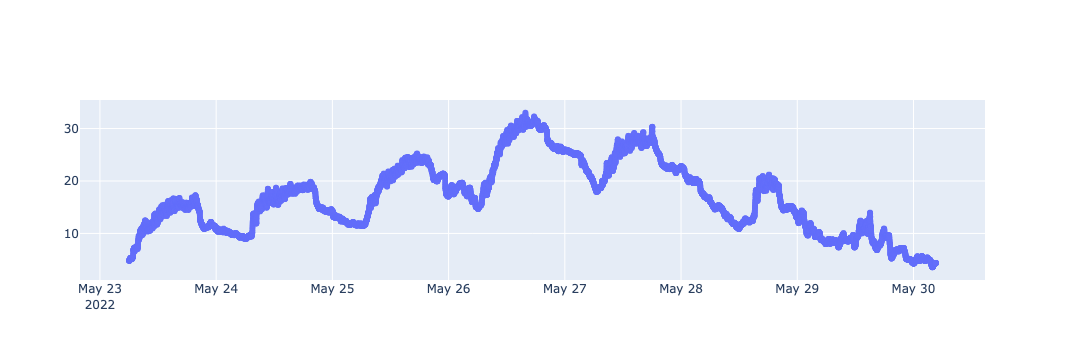

In [218]:
met_df_mini = met_df.iloc[0:10000]
fig = go.Figure()
fig.add_trace(go.Scatter(
        x = met_df_mini.index,
        y = met_df_mini['air_temp_set_1'],
        mode='markers',
        #marker={'size':5},
        #name = f'{column[0:2]}:{column[2:4]}:{column[4:6]}'
    ))
fig.show()

# Slant Columns: A Step By Step Description

Our goal is to create a list of receptor details (datetime, lat, lon, zagl) that can be used as an input to the STILT model for footprint analyses.

The required input variables to accomplish this are the latitude, longitude, and elevation (m above sea level) of the solar spectrometer (EM27), the datetime of the measurment, and the vertical levels at which we want to release particles.

The output should be a file formatted such that it can be read by STILT for particle releases. 

For the purpose of this description, we will do things with manual inputs. The final code version will do these steps with input data directly from the EM27 oof files, but for the sake of description we will input the instrument location and measurment time manually. 

The following description is effectively a step by step of ac_funcs.em27_slant_handler.run_manual(). 

1. First set up the em27 slant handler class that we will be describing in this excersize

In [9]:
hrrr_subset_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Atmos_Column/hrrr' #path with a hrrr folder included, or will be created
em27_data_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR/Data/SLC_EM27_ha_2022_oof_v2/'#this is where the EM27 data is 
output_path = '/uufs/chpc.utah.edu/common/home/u0890904/' #where output data will go

# hrrr_subset_path = '/Users/agmeyer4/LAIR_1/Atmos_Column/hrrr' #path with a hrrr folder included, or will be created
# em27_data_path = '/Users/agmeyer4/Google Drive/My Drive/Documents/LAIR/Data/SLC_EM27_ha_2022_oof_v2/' #this is where the EM27 data is 
# output_path = '/Users/agmeyer4/Desktop' #where output data will go

hrrr_subset_datestr = '2022-07-01 00:00' #this is the date that we want to take the surface information from. They should be all the same.

ESH = ac.em27_slant_handler(hrrr_subset_path,em27_data_path,output_path,hrrr_subset_datestr=hrrr_subset_datestr)

2. Define our receptor location and datetime details. Again, this will be done with the OOF file in typical use.

In [10]:
#First define the instrument location and elevation
inst_lat = 40.766
inst_lon = -111.847
inst_zasl = 1492 #instrument elevation in meters above sea level

#Next define the datetime of the measurment, and format it so we can use it in our algorithms
year = 2020
month = 12
day = 21
hour = 8
minute = 0
second = 1.1
tz = 'US/Mountain' 

#Now format the datetime and timezone into useful formats
dt_str,tz_dt = ac.format_datetime(year,month,day,hour,minute,second,tz=tz) #format the datetime

3. Next we define the vertical levels from which we wish to release particles. Starting point of level release heights (above the level of the instrument) for now is Taylor Jones' Indianapolis work (https://doi.org/10.5194/acp-21-13131-2021)

In [11]:
#Define the heights above the instrument (in m) from which we would like to release particles
z_ail_list = [0,25,50,75,100,150,200,300,400,600,1000,1500,2000,2500]

Lets plot the particle release heights above the instrument

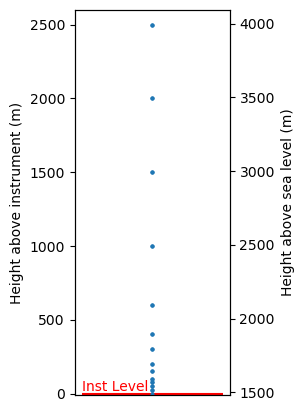

In [12]:
#Simple plot to show the particle release heights both above the instrument and above sea level

# Create the list of particle release elevations above sea level -- this is done in ac.load_singletime_hgtdf (in a cell below), but show it manually for now:
z_asl_list = [x+inst_zasl for x in z_ail_list]

#Make the plot
x = np.zeros_like(z_ail_list)
fig,ax = plt.subplots(figsize = (2,5))
ax.scatter(x,z_ail_list,s=4)
ax.set_ylabel('Height above instrument (m)')
ax.set_ylim([min(z_ail_list)-10,max(z_ail_list)+100])
ax2 = ax.twinx()
ax2.scatter(x,z_asl_list,s=4)
ax2.set_ylabel('Height above sea level (m)')
ax2.set_ylim([min(z_asl_list)-10,max(z_asl_list)+100])
ax.hlines(0,-1,1,color='red')
ax.tick_params(labelbottom = False, bottom = False)
ax.text(-1,20,'Inst Level',color='red')
plt.show()

4. With the above input parameters, we're ready to start building our dataframe of receptor locations. Because we are releasing particles at a vertical level above the instrument location *along the slanted column of the sun*, we need to find the lat/lon coordinates of each receptor point along that slanted column. 

    To do this, we use the ac.load_singletime_hgtdf() to build the dataframe. This function uses the ac.slant_lat_lon() function to get the new coordinates. We use basic geometry and an ellipsoid earth model to output lat/lon of the release points on the slant column given the datetime of the observation (for calculating what the slant column looks like). 

In [13]:
slant_df = ac.load_singletime_hgtdf(inst_lat,inst_lon,inst_zasl,tz_dt,z_ail_list) #create the dataframe from the inputs

Now we have a dataframe (slant_df) that has receptors at each of our input z release points, with the correct latitude longitude of those points along the slant column. We can visualize it below using a helping plotly function. 

In [14]:
plotting.create_slant_plots(slant_df,inst_lat,inst_lon)

5. STILT uses receptor heights **above ground level** not above sea level, so we must account for this. To do so, we use surface height elevation from HRRR .grib2 files.

In [15]:
# Running this will load the xarray dataset and dataframe from a hrrr file. If it isn't downloaded already, it will be downloaded to the hrrr_subset path. 
hrrr_elev_xarr_ds,hrrr_elev_df = ESH.load_hrrr_surf_hgts()

With the hrrr dataset loaded, we now need to find the surface height for each point in our receptor slant_df. Basically we take the lat/lon of the receptor and find the nearest grid cell in the hrrr dataset by setting a distance value for each centerpoint. From the minimum distance value, we grab the surface elevation. 

In [16]:
# This shows how we are getting the surface elevation for a point. In this case, we use the instrument location and extract the height. This is ac.get_nearest_from_grid()
lat_name='gridlat_0'
lon_name='gridlon_0'
pt_lat = inst_lat
pt_lon = inst_lon
colname_to_extract='HGT_P0_L1_GLC0'
df = hrrr_elev_df.loc[(hrrr_elev_df[lon_name]>=pt_lon-.1)&
            (hrrr_elev_df[lon_name]<=pt_lon+.1)&
            (hrrr_elev_df[lat_name]>=pt_lat-.1)&
            (hrrr_elev_df[lat_name]<=pt_lat+.1)] #filter df to 0.1 degrees around the point to speed up processs
df['dist'] = np.vectorize(ac.haversine)(df[lat_name],df[lon_name],pt_lat,pt_lon) #add a distance column for each subpoint using haversine
idx = df['dist'].idxmin() #find the minimum distance
nearest = df.loc[idx]
surface_height = df.loc[idx][colname_to_extract] #return the value requested

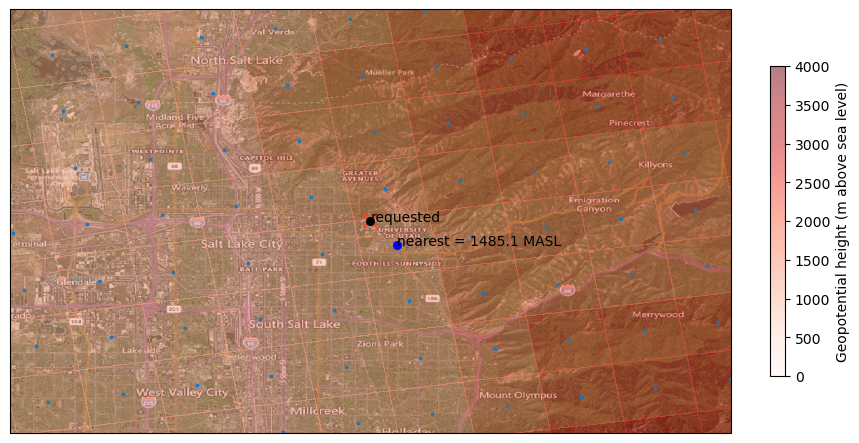

In [17]:
center_pt = [inst_lat,inst_lon]
zoom = 0.1
extent = [center_pt[1]-(zoom*1.7),center_pt[1]+(zoom*1.7),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)
ax.set_extent(extent,crs=proj)
request = cimgt.QuadtreeTiles()
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
ax.add_image(request,int(scale))
ax.scatter(center_pt[1],center_pt[0],marker='x',color='red',s=100)
map = hrrr_elev_xarr_ds.HGT_P0_L1_GLC0.plot.pcolormesh('gridlon_0','gridlat_0',ax = ax,alpha=0.5,vmin=0,vmax=4000,cmap='Reds',add_colorbar=False)
plt.colorbar(map,fraction=0.02,label ='Geopotential height (m above sea level)')
plt.scatter(hrrr_elev_xarr_ds.gridlon_0,hrrr_elev_xarr_ds.gridlat_0,s=3)
plt.scatter(inst_lon,inst_lat,s=30,c='black')
plt.text(inst_lon,inst_lat,'requested')
plt.scatter(nearest['gridlon_0'],nearest['gridlat_0'],s=30,c='blue')
plt.text(nearest['gridlon_0'],nearest['gridlat_0'],f'nearest = {round(surface_height,1)} MASL')
plt.show()

Using the above, we adapt the slant_df to have the surface elevations and the appropriate "above ground level" elevations for each receptor. We also add a column that indicates whether the receptor is actually above the ground level. In the case of a low sun angle over the mountains, the receptor points can be "below ground level" so we want to know which points this is true for. 

In [18]:
slant_df = ac.add_sh_and_agl(slant_df,hrrr_elev_df)

Now we can plot the slant column with the above ground level information.

In [19]:
plotting.create_slant_plots(slant_df,inst_lat,inst_lon)

### The above shows the slant column creation from a single, manual instrument location and datetime. We also want to be able to create these from saved oof files. This workflow is described below.

The difference here is using the ac.oof_manager class. This will allow us to run the em27_slant_handler in run_singleday_fromoof mode for each oof file in a folder. This is a more intensive computational process, as we need to calculate the slant column for each interferogram (1000+ per day). 

1. Setup the oof manager, and get the applicable oof files in a range that we want to analyze. 

In [21]:
dt1_str = '2022-06-02 08:55:00' #start datetime
dt2_str = '2022-06-02 17:00:00' #end datetime
timezone='US/Mountain' #timezone of intstrument

hrrr_subset_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Atmos_Column/hrrr' #path with a hrrr folder included, or will be created
em27_data_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR/Data/SLC_EM27_ha_2022_oof_v2/'#this is where the EM27 data is 
output_path = '/uufs/chpc.utah.edu/common/home/u0890904/' #where output data will go

# hrrr_subset_path = '/Users/agmeyer4/LAIR/hrrr/'
# oof_data_folder = '/Users/agmeyer4/Google Drive/My Drive/Documents/LAIR/Data/SLC_EM27_ha_2022_oof_v2/'
# output_path = '/Users/agmeyer4/Desktop'

ESH = ac.em27_slant_handler(hrrr_subset_path,em27_data_path,output_path,hrrr_subset_datestr='2022-07-01 00:00')
my_oof_manager = ac.oof_manager(em27_data_path,timezone)
oof_files_inrange = my_oof_manager.get_oof_in_range(dt1_str,dt2_str)

Here we would loop through all of the oof_files in the range, but for sake of description, just use the first one. 

In [22]:
oof_filename = oof_files_inrange[0]
oof_df = my_oof_manager.load_oof_df_inrange(dt1_str,dt2_str,oof_filename)

2. Now we can run get_slant_df_from_oof. This function creates a multi-indexed dataframe like slant_df, except with datetime as the first index and the z elevations above the instrument level as the second index. This can take a long time for a full oof file. 

In [23]:
slant_df_from_oof = ac.get_slant_df_from_oof(oof_df,z_ail_list,hrrr_elev_df)

Adding receptor lat/lons along the slant column
Adding surface height and receptor elevation above ground level


Here we can plot and show the multi df. Since there are many rows, we just plot those "on the hour" to show the change throughout the day. 

In [24]:
plotting.create_slant_plots(slant_df_from_oof,inst_lat,inst_lon,hourly_only=True)